## Estimating TR-XSS Signals of the Korovina 2018 system - Beamtime Application plot

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import os, sys, glob, matplotlib

%matplotlib widget
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('axes.formatter', limits= (-4, 4))
plt.rcParams.update({'font.size': 15})

import numpy as np
from ase import Atoms
from ase.io import read, write
from ase.io.trajectory import Trajectory

# all things that can be installed with pip
import nglview as nv
from grsq import Debye
from noise_estimator import NoiseEstimator 
from analysis import Korovina, weigh
from tqdm.notebook import tqdm

def make_colors(c, colmap='viridis'):
    import matplotlib.pyplot as plt
    cmap = plt.get_cmap(colmap)
    colors = [cmap(1.*i/c) for i in range(c)]
    return colors

### 0 vs 60 degrees 
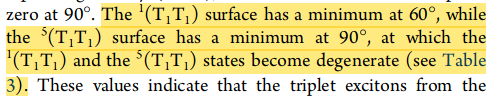

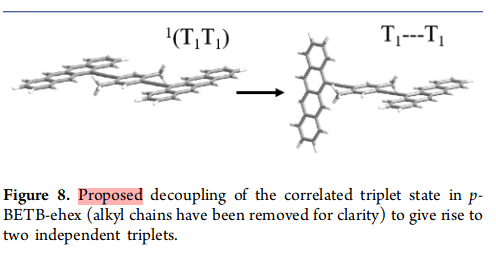


The figure caption says it's ehex 0 vs 60 degrees and that they've just removed the R groups for clarity.


So lets just take the CREST result closest to 0 and the one closest to 60 degrees, and calculate $\Delta S(Q)$ from that.

In [108]:
# let's have a look at the conformers, aligned to the linker to make it easier to look at.
aligned_traj = Trajectory('data/crest_conformers_aligned.traj', 'r')
nv.show_asetraj(aligned_traj)

NGLWidget(max_frame=20207)

In [109]:
len(aligned_traj)

20208

The trajectory doesn't contain energies or angles, but we don't trust them anyway. We DO trust XTB to position the R-groups in an energetically stable position for each twisting angle, however. 

So therefore we can just use this trajectory, find 0 deg and 60 deg, and calculate the scattering from those two discrete structures. You could consider adding a bit of "heat" by averaging over a range of twists around 0 and 60, if you wanted to be fancy... 

In [110]:
ehex_s0_thf_a = np.zeros(len(aligned_traj))
for i, atoms in enumerate(aligned_traj):
    tmp = Korovina(mol='ehex')
    ehex_s0_thf_a[i] = tmp.calc_angle(atoms)

In [111]:
idx_coplanar = np.argmin(ehex_s0_thf_a)
idx_twisted  = np.argmin(np.abs(ehex_s0_thf_a - 60))
coplanar = aligned_traj[idx_coplanar]
twisted  = aligned_traj[idx_twisted]


nv.show_asetraj([coplanar, twisted])

NGLWidget(max_frame=1)

### Absolutely simplest version: discrete structures 60 deg - 0 deg

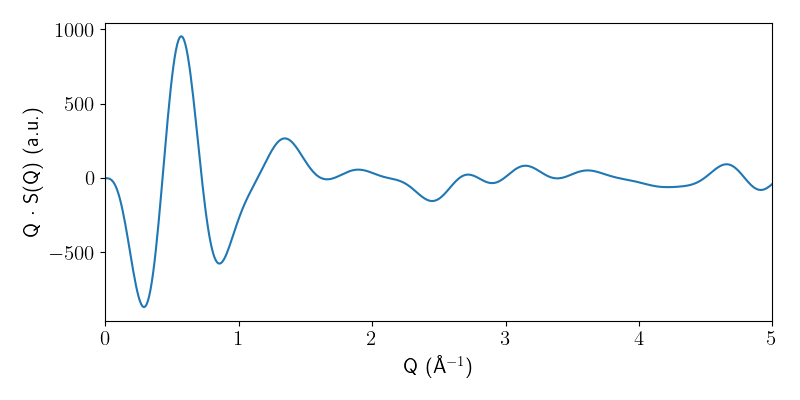

In [51]:
qvec = np.arange(0, 9, 0.01)
deb = Debye(qvec=qvec)
sq = np.zeros((2, len(qvec)))
for i, atoms in enumerate((coplanar, twisted)): # GS, ES
    sq[i] = deb.debye(atoms)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(qvec, qvec * (sq[1] - sq[0]))
ax.set_xlabel('Q (Å$^{-1}$)')
ax.set_ylabel('Q $\cdot$ S(Q) (a.u.)')

ax.set_xlim([0, 5])
fig.tight_layout()

But it's _not_ very likely that the actual system will be in _only_ these two conformers, where the twisted version happens to have an R group very close to one of its chromophores... 

### Lets filter out all conformers $\pm$ 2.5 deg from the two conformers, calc averages. 

Just in case the various R group locations would change a lot

In [52]:
mask_cop = np.zeros(len(aligned_traj), bool)
mask_cop[(ehex_s0_thf_a < 2.5) | (ehex_s0_thf_a > 360 - 2.5)] = True
idx_cop = np.where(mask_cop)[0]
cop_dist = [atoms for i, atoms in enumerate(aligned_traj) if i in idx_cop]

In [53]:
nv.show_asetraj(cop_dist)

NGLWidget(max_frame=191)

As I expected, many of these do _not_ have the previous conformation that is great for scattering

In [54]:
mask_twi = np.zeros(len(aligned_traj), bool)
mask_twi[(ehex_s0_thf_a > 60 - 2.5) & (ehex_s0_thf_a < 60 + 2.5)] = True
idx_twi = np.where(mask_twi)[0]
twi_dist = [atoms for i, atoms in enumerate(aligned_traj) if i in idx_twi]
nv.show_asetraj(twi_dist)

NGLWidget(max_frame=299)

Lets check that the two sub populations are at least kinda similar in size

In [55]:
len(cop_dist), len(twi_dist)

(192, 300)

Instead of calculating the scattering from 2 structures, I now have to do it for 492, so I'm speeding it up with the `numba` implementation.. That should also be installable via pip, but if it fails, you can remove `_numba` and the cell below will run, albeit slower

In [56]:
from tqdm.notebook import tqdm

qvec = np.arange(0, 5, 0.02)
deb = Debye(qvec=qvec)

sq_es = np.zeros((len(twi_dist), len(qvec)))
sq_gs = np.zeros((len(cop_dist), len(qvec)))

for i, atoms in tqdm(enumerate(cop_dist), total=len(cop_dist)): # GS
    sq_gs[i] = deb.debye_numba(atoms)

for i, atoms in tqdm(enumerate(twi_dist), total=len(twi_dist)): # ES
    sq_es[i] = deb.debye_numba(atoms)



  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

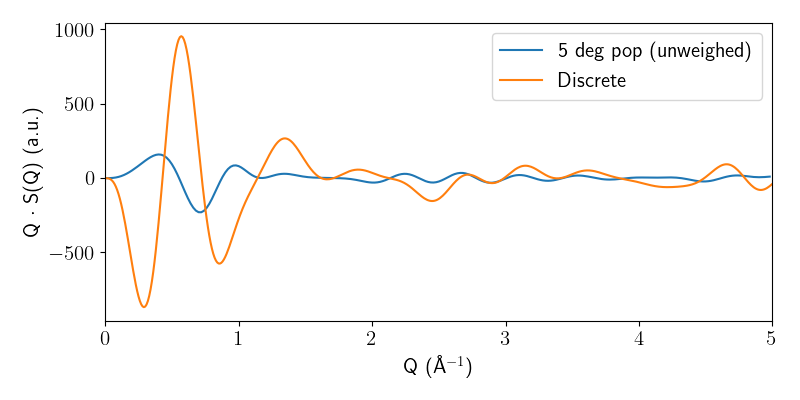

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(qvec, qvec * (sq_es.mean(0) - sq_gs.mean(0)), label='5 deg pop (unweighed)')
ax.plot(np.arange(0, 9, 0.01), 
        np.arange(0, 9, 0.01) * (sq[1] - sq[0]), label='Discrete')
ax.set_xlabel('Q (Å$^{-1}$)')
ax.set_ylabel('Q $\cdot$ S(Q) (a.u.)')
ax.legend(loc='upper right')
ax.set_xlim([0, 5])
fig.tight_layout()

### As expected, the signal decreases _a lot_

The scattering should of course be weighed with the energies, 
but that's a bit hard if we don't trust the XTB energies... So first...

... let's do everything again for $\pm 0.5$ deg instead muahah

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

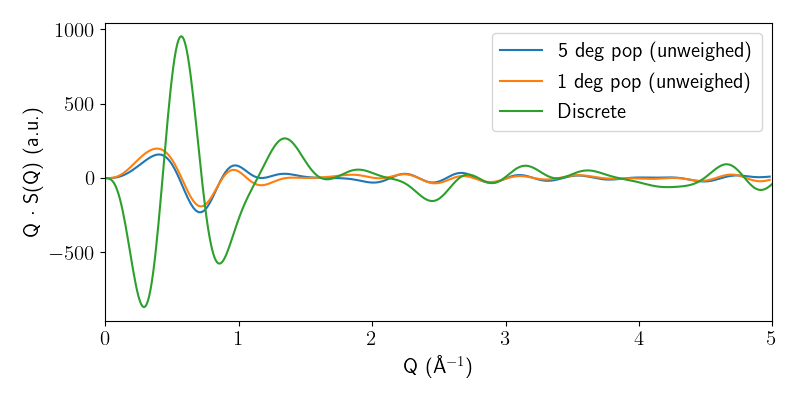

In [58]:
ad = 0.5
def calc_scat(aligned_traj, ad, qvec=None):
    mask_cop = np.zeros(len(aligned_traj), bool)
    mask_cop[(ehex_s0_thf_a < ad) | (ehex_s0_thf_a > 360 - ad)] = True
    idx_cop = np.where(mask_cop)[0]
    cop_dist = [atoms for i, atoms in enumerate(aligned_traj) if i in idx_cop]

    mask_twi = np.zeros(len(aligned_traj), bool)
    mask_twi[(ehex_s0_thf_a > 60 - ad) & (ehex_s0_thf_a < 60 + ad)] = True
    idx_twi = np.where(mask_twi)[0]
    twi_dist = [atoms for i, atoms in enumerate(aligned_traj) if i in idx_twi]
    
    if qvec is None:
        qvec = np.arange(0, 5, 0.02)
    deb = Debye(qvec=qvec)

    sq_es = np.zeros((len(twi_dist), len(qvec)))
    sq_gs = np.zeros((len(cop_dist), len(qvec)))

    for i, atoms in tqdm(enumerate(cop_dist), total=len(cop_dist)): # GS
        sq_gs[i] = deb.debye_numba(atoms)

    for i, atoms in tqdm(enumerate(twi_dist), total=len(twi_dist)): # ES
        sq_es[i] = deb.debye_numba(atoms)
    
    return sq_gs, sq_es

sq_gs1, sq_es1 = calc_scat(aligned_traj, ad)
    
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(qvec, qvec * (sq_es.mean(0) - sq_gs.mean(0)), label='5 deg pop (unweighed)')
ax.plot(qvec, qvec * (sq_es1.mean(0) - sq_gs1.mean(0)), label=f'1 deg pop (unweighed)')
ax.plot(np.arange(0, 9, 0.01), 
        np.arange(0, 9, 0.01) * (sq[1] - sq[0]), label='Discrete')
ax.set_xlabel('Q (Å$^{-1}$)')
ax.set_ylabel('Q $\cdot$ S(Q) (a.u.)')
ax.legend(loc='upper right')
ax.set_xlim([0, 5])
fig.tight_layout()

Let's confirm 100% that the increase in signal arises from the change in positions of the R groups wrt the chromopores, we do that by going back to the discrete, 2 conformer calculation, but leaving out all debye terms from the R groups:

In [59]:
rgroup_idx = [59, 98, 55, 100, 101, 102, 103, 104, 107, 109, 111, 112, 113, 108, 105, 110, 106, 99, 60, 118,
              114, 115, 116, 119, 117, 
              73,74, 77, 82, 85, 78, 90, 94, 83, 75, 76, 79, 86, 84, 81, 91, 89, 93, 80, 97, 95, 96, 92, 87, 88]
len(rgroup_idx)

atoms = aligned_traj[0]

idx = [i for i in range(len(atoms)) if i not in rgroup_idx]
nv.show_ase(atoms[idx])

NGLWidget()

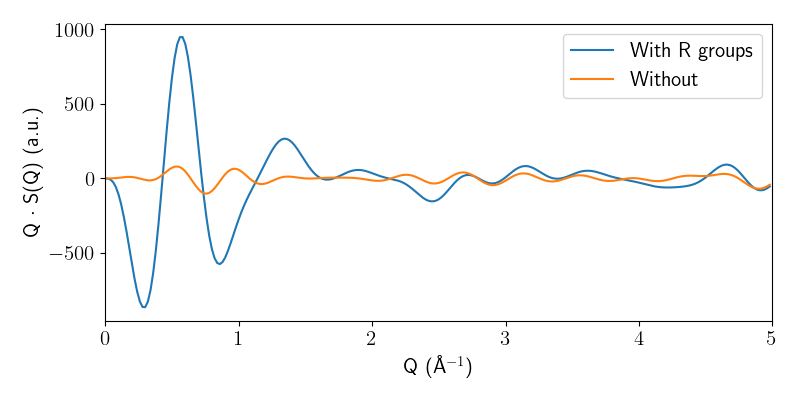

In [60]:
qvec = np.arange(0, 5, 0.02)
deb = Debye(qvec=qvec)
sq_no_r = np.zeros((2, len(qvec)))
sq = np.zeros((2, len(qvec)))
for i, atoms in enumerate((coplanar, twisted)): # GS, ES
    sq_no_r[i] = deb.debye_selective(atoms, idx, idx)
    sq[i] = deb.debye(atoms)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(qvec, qvec * (sq[1] - sq[0]), label='With R groups')
ax.plot(qvec, qvec * (sq_no_r[1] - sq_no_r[0]), label='Without')
ax.set_xlabel('Q (Å$^{-1}$)')
ax.set_ylabel('Q $\cdot$ S(Q) (a.u.)')
ax.legend(loc='best')
ax.set_xlim([0, 5])
fig.tight_layout()

Exactly what I was afraid of... 

### Noise and scale to FeBPY signal

In [80]:
ne = NoiseEstimator(accu_time=600, photons_pulse=1e11, reprate=100)
noise_diff = ne.calc_noise()

# recalc scattering with ref qvec
qvec = ne.qvec
deb = Debye(qvec)
sq_no_r = np.zeros((2, len(qvec)))
sq = np.zeros((2, len(qvec)))
for i, atoms in enumerate((coplanar, twisted)): # GS, ES
    sq_no_r[i] = deb.debye_selective(atoms, idx, idx)
    sq[i] = deb.debye(atoms)

hs = read('ref/FeBPY_HighSpinDFT.xyz')
ls = read('ref/FeBPY_LowSpinDFT.xyz')

s_ls = deb.debye(ls)
s_hs = deb.debye(hs)


  0%|          | 0/60000 [00:00<?, ?it/s]

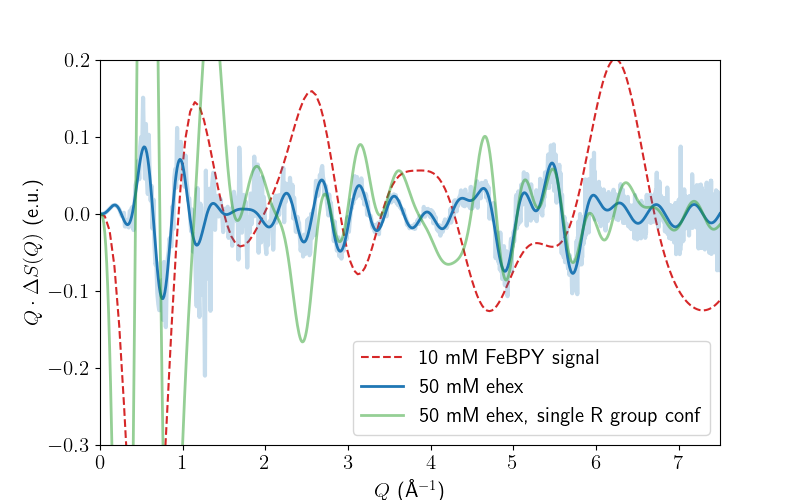

In [68]:
# Sample parameters
dens = 779    # solvent density, kg/m^3 - cyclohexane
mw = 0.08416  # solvent molar mass, kg/mol (cyclohexane)
conc = 50     # solute concentration, mM
conc_scale = dens / mw / conc  # scale solute scattering according to concentration
conc_scale_10mM = dens / mw / 10  # scale solute scattering according to concentration
frac_exc = 0.2  # how many of the pulses are exciting molecules
frac_yield = 1  # how many of the excited molecules are doing what we want

exp_scale = frac_exc * frac_yield / conc_scale
exp_scale_10mM = frac_exc * frac_yield / conc_scale_10mM

ds_no_r = sq_no_r[1] - sq_no_r[0]
ds = sq[1] - sq[0]


fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(qvec[::5], qvec[::5] *  (s_hs-s_ls)[::5] * exp_scale_10mM * 2, 'C3--', label=f'10 mM FeBPY signal', ms=5, mfc='None', mew=2)
ax.plot(qvec, qvec * ds_no_r * exp_scale, 'C0', label=f'{conc} mM ehex', lw=2)
ax.plot(qvec, qvec * (ds_no_r * exp_scale + noise_diff), 'C0', lw=3, alpha=0.25)
ax.plot(qvec, qvec * ds * exp_scale, 'C2-', label=f'{conc} mM ehex, single R group conf', lw=2, alpha=0.5)

ax.set_xlim([0, 7.5])
ax.set_ylim([-.3, .2])
ax.set_ylabel('$Q \cdot \Delta S(Q)$ (e.u.)')
ax.set_xlabel('$Q$ (Å$^{-1}$)')
ax.legend(loc='best')

Here I've had to increase the ehex concentration to 50mM to get even _some_ kind of signal amplitude. 

Finally, let us assume that the XTB energies are trustworthy (lol, but the CENSO calcs are still running), and do a weighed mean of the scattering based on the electronic XTB energies. 

For that we need, well, the energies, and the indicies of the used conformers of the total ensemble.

In [70]:
aligned_traj = Trajectory('data/crest_conformers_aligned.traj', 'r')

energies = np.genfromtxt('data/energies.dat')[:, 0]

ad = 2.5  # total of 5 deg

mask_cop = np.zeros(len(aligned_traj), bool)
mask_cop[(ehex_s0_thf_a < ad) | (ehex_s0_thf_a > 360 - ad)] = True

mask_twi = np.zeros(len(aligned_traj), bool)
mask_twi[(ehex_s0_thf_a > 60 - ad) & (ehex_s0_thf_a < 60 + ad)] = True

sq_gs, sq_es = calc_scat(aligned_traj, ad, qvec=qvec)

gs_weighed = np.sum(sq_gs * weigh(energies, mask=mask_cop), axis=0)
es_weighed = np.sum(sq_es * weigh(energies, mask=mask_twi), axis=0)

#es_weighed = np.sum(es_scat * weigh(energies_q1, mask=None), axis=0)

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

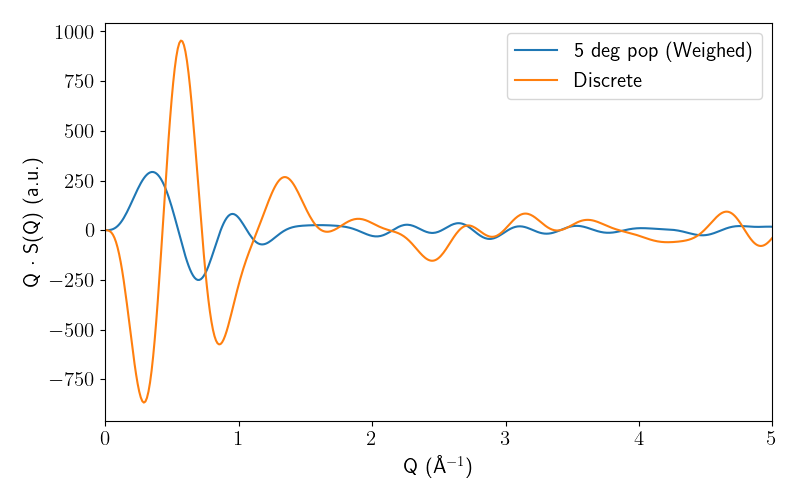

In [71]:
sq = np.zeros((2, len(qvec)))
for i, atoms in enumerate((coplanar, twisted)): # GS, ES
    sq[i] = deb.debye(atoms)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(qvec, qvec * (es_weighed - gs_weighed), label='5 deg pop (Weighed)')
ax.plot(qvec, qvec * (sq[1] - sq[0]), label='Discrete')
ax.set_xlabel('Q (Å$^{-1}$)')
ax.set_ylabel('Q $\cdot$ S(Q) (a.u.)')
ax.legend(loc='upper right')
ax.set_xlim([0, 5])
fig.tight_layout()

I mean it's a _bit_ better than the unweighed? 

## Weighed population scattering + Noise and Exp. scaling

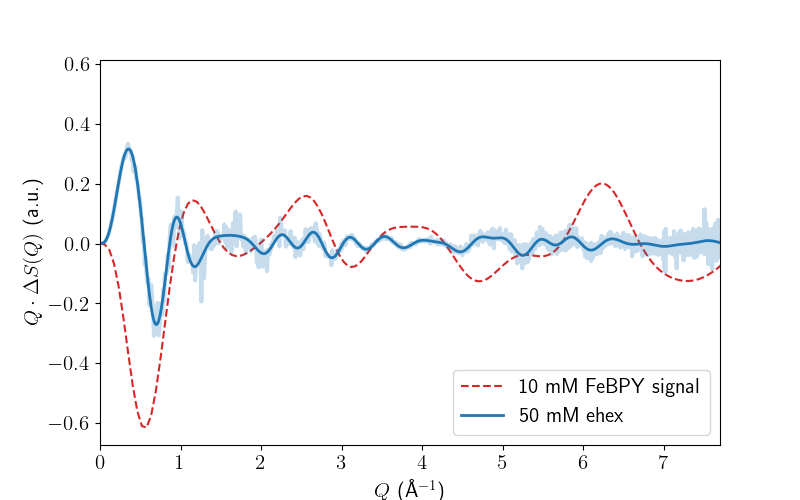

In [85]:
# Sample parameters
dens = 779    # solvent density, kg/m^3 - cyclohexane
mw = 0.08416  # solvent molar mass, kg/mol (cyclohexane)
conc = 50     # solute concentration, mM
conc_scale = dens / mw / conc  # scale solute scattering according to concentration
conc_scale_10mM = dens / mw / 10  # scale solute scattering according to concentration
frac_exc = 0.2  # how many of the pulses are exciting molecules
frac_yield = 1  # how many of the excited molecules are doing what we want

exp_scale = frac_exc * frac_yield / conc_scale
exp_scale_10mM = frac_exc * frac_yield / conc_scale_10mM

ds = es_weighed - gs_weighed

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
# reference:
ax.plot(qvec[::5], qvec[::5] *  (s_hs-s_ls)[::5] * exp_scale_10mM * 2, 'C3--', label=f'10 mM FeBPY signal', ms=5, mfc='None', mew=2)
# weighed pop, noise and no-noise
ax.plot(qvec, qvec * ds * exp_scale, 'C0', label=f'{conc} mM ehex', lw=2)
ax.plot(qvec, qvec * (ds * exp_scale + noise_diff), 'C0', lw=3, alpha=0.25)


ax.set_xlim([0, 7.7])
#ax.set_ylim([-.3, .2])
ax.set_ylabel('$Q \cdot \Delta S(Q)$ (a.u.)')
ax.set_xlabel('$Q$ (Å$^{-1}$)')
ax.legend(loc='lower right')

So.. for large enough concentrations, and if we have low Q range, I suppose we stand a chance? 

The noise level is for 10 minute/point scans. 

## HTI reference

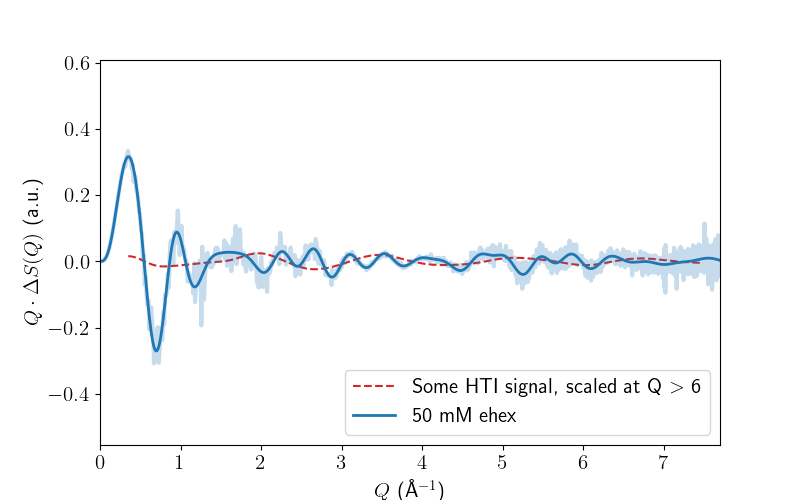

In [106]:
hti = np.genfromtxt('ref/htij_ds_ct_90twist_acn_sim.dat', skip_header=1)

scaled_korovina = ds * exp_scale
k_mask = np.zeros(len(scaled_korovina), bool)
k_mask[qvec > 6] = True

h_mask = np.zeros(len(hti), bool)
h_mask[hti[:, 0] > 6] = True

scale = np.abs(scaled_korovina[k_mask]).mean() / np.abs(hti[h_mask, 2]).mean()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
# reference:
ax.plot(hti[:, 0], hti[:, 0] * hti[:, 2] * scale, 'C3--', label=f'Some HTI signal, scaled at Q $>$ 6')

# weighed pop, noise and no-noise
ax.plot(qvec, qvec * ds * exp_scale, 'C0', label=f'{conc} mM ehex', lw=2)
ax.plot(qvec, qvec * (ds * exp_scale + noise_diff), 'C0', lw=3, alpha=0.25)


ax.set_xlim([0, 7.7])
#ax.set_ylim([-.3, .2])
ax.set_ylabel('$Q \cdot \Delta S(Q)$ (a.u.)')
ax.set_xlabel('$Q$ (Å$^{-1}$)')
ax.legend(loc='lower right')

Maaaybe this scaling was a bit too fresh... THe signal can't be _THAT_ small.. We need to find out how the .dat files are scaled. 

## Range of twist angles - You can start running cells from here
This will be the plot that ends up in the application

In [2]:
aligned_traj = Trajectory('data/crest_conformers_aligned.traj', 'r')
nv.show_asetraj(aligned_traj)

NGLWidget(max_frame=20207)

In [3]:
ehex_s0_thf_a = np.zeros(len(aligned_traj))
for i, atoms in enumerate(aligned_traj):
    tmp = Korovina(mol='ehex')
    ehex_s0_thf_a[i] = tmp.calc_angle(atoms)

Make a few mods to the scattering calculation to speed it up by not calculating the GS redundantly, and also get out the masks selecting the correct isomers, for the weighing

In [4]:
def calc_scat(aligned_traj, ad, es_angle, qvec=None, calc_gs=True):
    mask_cop = np.zeros(len(aligned_traj), bool)
    mask_cop[(ehex_s0_thf_a < ad) | (ehex_s0_thf_a > 360 - ad)] = True
    idx_cop = np.where(mask_cop)[0]
    cop_dist = [atoms for i, atoms in enumerate(aligned_traj) if i in idx_cop]

    mask_twi = np.zeros(len(aligned_traj), bool)
    mask_twi[(ehex_s0_thf_a > es_angle - ad) & (ehex_s0_thf_a < es_angle + ad)] = True
    idx_twi = np.where(mask_twi)[0]
    twi_dist = [atoms for i, atoms in enumerate(aligned_traj) if i in idx_twi]
    
    if qvec is None:
        qvec = np.arange(0, 5, 0.02)
    deb = Debye(qvec=qvec)

    sq_es = np.zeros((len(twi_dist), len(qvec)))
    sq_gs = np.zeros((len(cop_dist), len(qvec)))

    if calc_gs:
        for i, atoms in tqdm(enumerate(cop_dist), total=len(cop_dist)): # GS
            sq_gs[i] = deb.debye_numba(atoms)

    for i, atoms in tqdm(enumerate(twi_dist), total=len(twi_dist)): # ES
        sq_es[i] = deb.debye_numba(atoms)
    
    return sq_gs, sq_es, mask_cop, mask_twi, twi_dist

Calculate the scattering signal from three twist angles: 20, 60, 90, 

In [5]:
ne = NoiseEstimator(accu_time=600, photons_pulse=1e11, reprate=100)
#noise_diff = ne.calc_noise()
qvec = ne.qvec

aligned_traj = Trajectory('data/crest_conformers_aligned.traj', 'r')

energies = np.genfromtxt('data/energies.dat')[:, 0]

ad = 2.5  # 

angles = [20, 60, 90]
all_weighed_es = np.zeros((len(angles), len(qvec)))

twist_dists = [[], [], [], []]
for i, angle in enumerate(angles):
    if i == 0:
        sq_gs, sq_es, mask_cop, mask_twi, twi_dist = calc_scat(aligned_traj, ad, angle, qvec=qvec)
    else:
        _, sq_es, mask_cop, mask_twi, twi_dist = calc_scat(aligned_traj, ad, angle, qvec=qvec, calc_gs=False)

    gs_weighed = np.sum(sq_gs * weigh(energies, mask=mask_cop), axis=0)
    es_weighed = np.sum(sq_es * weigh(energies, mask=mask_twi), axis=0)
    
    all_weighed_es[i, :] = es_weighed
    
    twist_dists[i] = twi_dist



  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

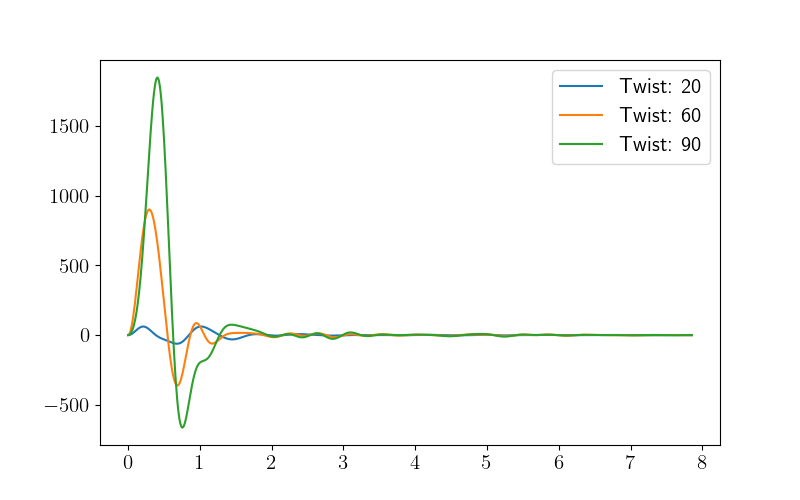

In [6]:
col = make_colors(len(angles))
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for a, es_ang in enumerate(all_weighed_es):
    ax.plot(qvec, es_ang  - gs_weighed, color=f'C{a}', label=f'Twist: {angles[a]:2.0f}')
    
ax.legend(loc='best')

### Great, now add noise

In [7]:
ne = NoiseEstimator(accu_time=600, photons_pulse=1e11, reprate=100)
noise_diff = ne.calc_noise()

  0%|          | 0/60000 [00:00<?, ?it/s]

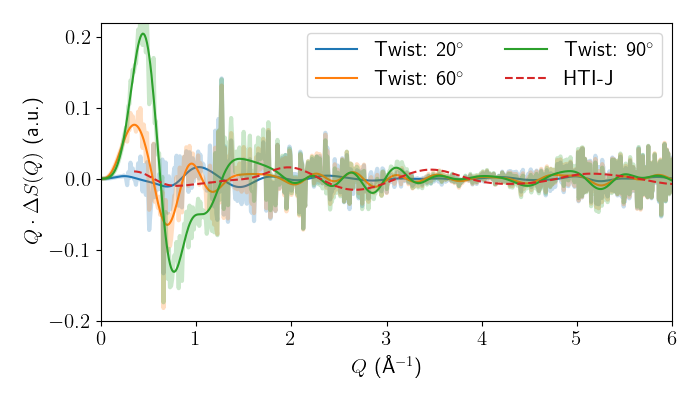

In [8]:
# Sample parameters
dens = 779    # solvent density, kg/m^3 - cyclohexane
mw = 0.08416  # solvent molar mass, kg/mol (cyclohexane)
conc = 12     # solute concentration, mM
conc_scale = dens / mw / conc  # scale solute scattering according to concentration
frac_exc = 0.2  # how many of the pulses are exciting molecules
frac_yield = 1  # how many of the excited molecules are doing what we want

exp_scale = frac_exc * frac_yield / conc_scale


hti = np.genfromtxt('ref/htij_ds_ct_90twist_acn_sim.dat', skip_header=1)



fig, ax = plt.subplots(1, 1, figsize=(7, 4))
for a, es_ang in enumerate(all_weighed_es):
    ax.plot(qvec, qvec *((es_ang  - gs_weighed) * exp_scale + noise_diff),
            color=f'C{a}', alpha=0.25, lw=3)

    ax.plot(qvec, qvec *((es_ang  - gs_weighed) * exp_scale),
            color=f'C{a}', label=f'Twist: {angles[a]:2.0f}$^\circ$')
    
ax.plot(hti[:, 0], hti[:, 0] * hti[:, 2], 'C3--', label=f'HTI-J')


        
ax.set_xlim([0, 6.0])
ax.set_ylim([-.20, .22])
ax.set_ylabel('$Q \cdot \Delta S(Q)$ (a.u.)')
ax.set_xlabel('$Q$ (Å$^{-1}$)')
ax.legend(loc='lower right')
ax.legend(loc='best', ncol=2)

fig.tight_layout()

In the plot above, the scattering signal is predicted by calculating a Boltzmann-weighed average of the Debye-scattering from a conformer ensemble generated with tight-binding DFT, using the calculated electronic energies of each individual conformer. For each twisting angle, we performed the weighed average on all sampled conformers within $\pm$ 5$^\circ$ of the twist reported in the legend. In this way we take into account the scattering from many possible conformations of the two side-groups of ehex, providing a more nuanced prediction than if simply calculating the scattering from two discrete structures (1 for the ground state and 1 for the excited state). In the plot above, the ground state scattering is also calculated from a $\pm$ 5$^\circ$ weighed window of ground state conformers around 0 degrees twist. 

### Again, but where we use HTI xyzs til calculate the signal ourselves

In [21]:
on = read('ref/htij_90twist.xyz')
off = read('ref/htij.xyz')

htideb = Debye(qvec=qvec)
hti_ds = htideb.debye(on) - htideb.debye(off)

## sample parameters for HTI
dens = 786    # solvent density, kg/m^3 - cyclohexane
mw = 0.08416  # solvent molar mass, kg/mol (cyclohexane)
conc = 2.5     # solute concentration, mM
conc_scale = dens / mw / conc  # scale solute scattering according to concentration
frac_exc = 0.2  # how many of the pulses are exciting molecules
frac_yield = 1  # how many of the excited molecules are doing what we want
hti_scale = frac_exc * frac_yield / conc_scale

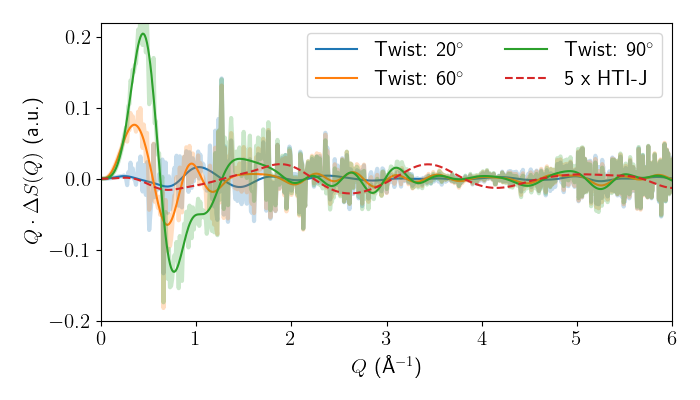

In [25]:
# Sample parameters
dens = 779    # solvent density, kg/m^3 - cyclohexane
mw = 0.08416  # solvent molar mass, kg/mol (cyclohexane)
conc = 12     # solute concentration, mM
conc_scale = dens / mw / conc  # scale solute scattering according to concentration
frac_exc = 0.2  # how many of the pulses are exciting molecules
frac_yield = 1  # how many of the excited molecules are doing what we want

exp_scale = frac_exc * frac_yield / conc_scale


hti = np.genfromtxt('ref/htij_ds_ct_90twist_acn_sim.dat', skip_header=1)



fig, ax = plt.subplots(1, 1, figsize=(7, 4))
for a, es_ang in enumerate(all_weighed_es):
    ax.plot(qvec, qvec *((es_ang  - gs_weighed) * exp_scale + noise_diff),
            color=f'C{a}', alpha=0.25, lw=3)

    ax.plot(qvec, qvec *((es_ang  - gs_weighed) * exp_scale),
            color=f'C{a}', label=f'Twist: {angles[a]:2.0f}$^\circ$')
    
#ax.plot(hti[:, 0], hti[:, 0] * hti[:, 2], 'C3--', label=f'HTI-J')
ax.plot(qvec, 5 * qvec * hti_ds * hti_scale, 'C3--', label=f'5 x HTI-J')


        
ax.set_xlim([0, 6.0])
ax.set_ylim([-.20, .22])
ax.set_ylabel('$Q \cdot \Delta S(Q)$ (a.u.)')
ax.set_xlabel('$Q$ (Å$^{-1}$)')
ax.legend(loc='lower right')
ax.legend(loc='best', ncol=2)

fig.tight_layout()